In [ ]:
!pip3 install -r requirements.txt

In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_log_error as RMSLE
from openfe import OpenFE, transform

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
sns.set_style(style="darkgrid")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
df0 = pd.read_csv("train.csv", delimiter=",")
X_val = pd.read_csv("test.csv", delimiter=",")
df0 = df0.rename(columns={
    "Whole weight": "Whole_weight",
    "Whole weight.1": "Shucked_weight",
    "Whole weight.2": "Viscera_weight",
    "Shell weight": "Shell_weight"
    })

X_val = X_val.rename(columns={
    "Whole weight": "Whole_weight",
    "Whole weight.1": "Shucked_weight",
    "Whole weight.2": "Viscera_weight",
    "Shell weight": "Shell_weight"
    })

df = df0.copy()
non_cat_features = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]
cat_features = ["Sex"]

df0

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


### 1. Проверка на выбросы

In [6]:
pd.DataFrame(df.isna().sum())

,0
id,0
Sex,0
Length,0
Diameter,0
Height,0
Whole_weight,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


In [7]:
pd.DataFrame(df.isna().sum())

,0
id,0
Sex,0
Length,0
Diameter,0
Height,0
Whole_weight,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


In [7]:
pd.DataFrame(X_val.isna().sum())

,0
id,0
Sex,0
Length,0
Diameter,0
Height,0
Whole_weight,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0


### 2. Проверка на выбросы

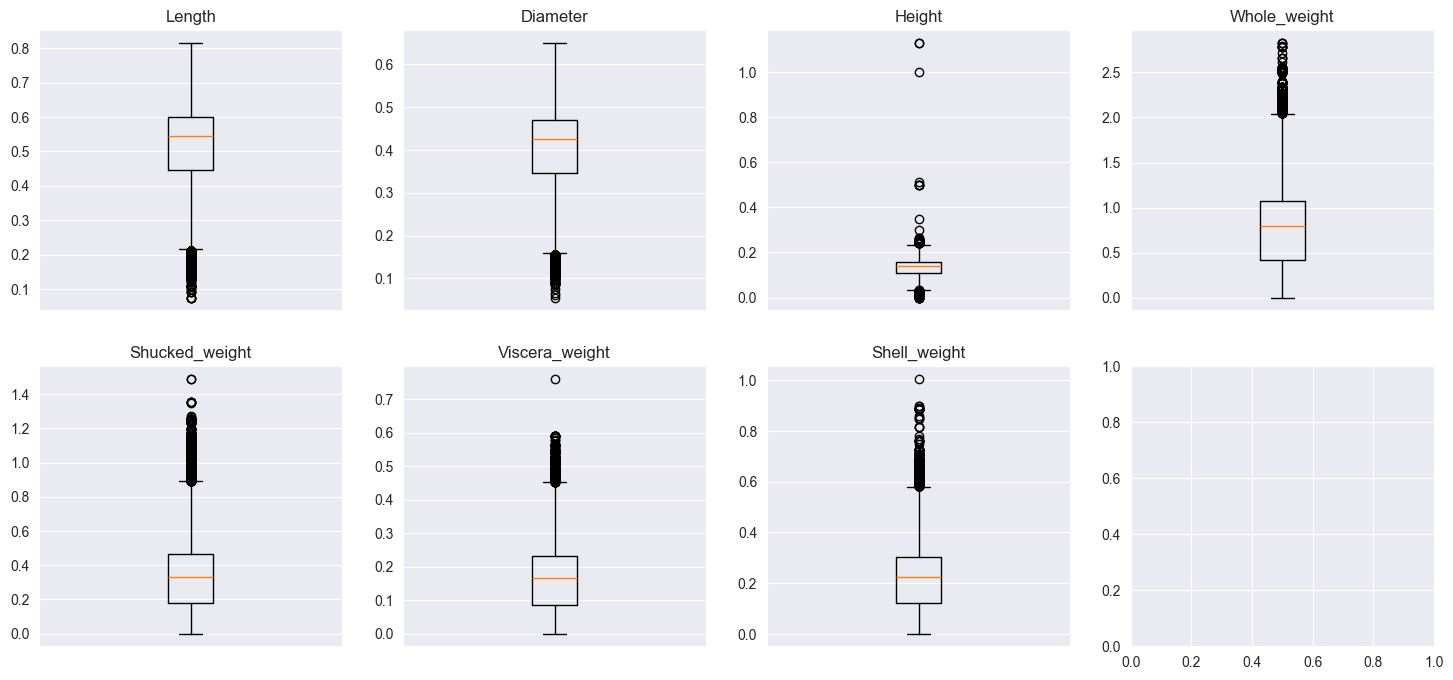

In [8]:
def check_outliers(_df: pd.DataFrame, whis: int = 3) -> None:
    _, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))

    for i, feature in enumerate(non_cat_features):
        if feature != "Sex":
            axs[i//4, i%4].boxplot(x=_df[feature], whis=whis)
            axs[i//4, i%4].set(title=feature)
            axs[i//4, i%4].get_xaxis().set_visible(False)

    plt.show()

whis = 1.5
check_outliers(df, whis)

В датасете осталось 87266 строк


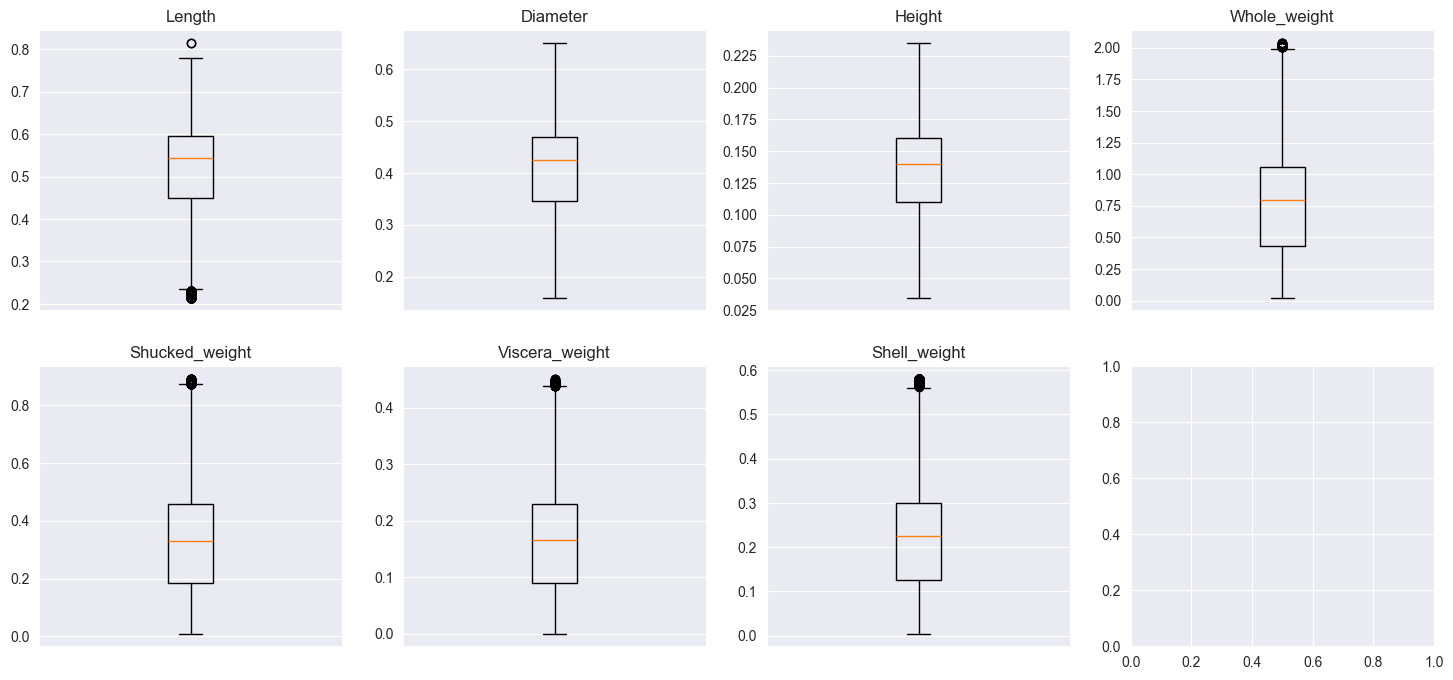

In [9]:
Q1, Q3 = df[non_cat_features].quantile(0.25), df[non_cat_features].quantile(0.75)
IQR = Q3 - Q1
top_lim, bottom_lim = Q3 + whis * IQR, Q1 - whis * IQR

mask = (df[non_cat_features] >= bottom_lim) & (df[non_cat_features] <= top_lim)
df = df[mask.all(axis=1)]

print(f"В датасете осталось {len(df)} строк")
check_outliers(df, whis)

### 3. Кодирование признаков.

Будем использовать модель градиентного бустинга CatBoost, для которой кодирование категориальных фичей не нужно (она делает это сама).


In [10]:
non_cat_features = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]
cat_features = ["Sex"]

X_train, y_train = df[non_cat_features + cat_features], df["Rings"]
X_train_CV, X_test_CV, y_train_CV, y_test_CV = train_test_split(X_train, y_train, test_size=0.23)

### 4. Трансформация признаков.

Произведем трансформацию таргета $\text{Rings} \rightarrow \log\left(1 + \text{Rings}\right)$, чтобы в дальнейшем использовать базовую метрику RMSE.

In [11]:
df["Rings"] = np.log1p(df["Rings"])

### 5. Генерация признаков.

Будем использовать автоматическую генерацию признаков.

In [12]:
ofe = OpenFE()
features = ofe.fit(data=X_train, label=y_train, n_jobs=4, seed=RANDOM_SEED, categorical_features=cat_features, verbose=False)
X_train_FE, X_valid_FE = transform(X_train, X_val, features, n_jobs=4)
X_train_FE

  0%|          | 0/16 [00:00<?, ?it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train

  6%|▋         | 1/16 [00:04<01:06,  4.46s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 25%|██▌       | 4/16 [00:04<00:10,  1.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to rem

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

 31%|███▏      | 5/16 [00:05<00:09,  1.16it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 44%|████▍     | 7/16 [00:05<00:04,  1.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to rem

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 50%|█████     | 8/16 [00:05<00:03,  2.26it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 56%|█████▋    | 9/16 [00:06<00:03,  1.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 69%|██████▉   | 11/16 [00:06<00:01,  2.92it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to re

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

 81%|████████▏ | 13/16 [00:07<00:00,  3.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mor

 88%|████████▊ | 14/16 [00:07<00:00,  3.29it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 94%|█████████▍| 15/16 [00:07<00:00,  3.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

100%|██████████| 16/16 [00:07<00:00,  2.00it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


  0%|          | 0/15 [00:00<?, ?it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.p

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` t

  7%|▋         | 1/15 [00:06<01:34,  6.74s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 13%|█▎        | 2/15 [00:06<00:37,  2.89s/it]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


 20%|██        | 3/15 [00:07<00:22,  1.91s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 27%|██▋       | 4/15 [00:07<00:13,  1.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to

 33%|███▎      | 5/15 [00:11<00:20,  2.07s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 40%|████      | 6/15 [00:11<00:12,  1.42s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 47%|████▋     | 7/15 [00:11<00:08,  1.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to

 53%|█████▎    | 8/15 [00:12<00:07,  1.04s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` t

 60%|██████    | 9/15 [00:15<00:10,  1.68s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_col_wise=true` t

 67%|██████▋   | 10/15 [00:16<00:07,  1.44s/it]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

 73%|███████▎  | 11/15 [00:17<00:04,  1.18s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 80%|████████  | 12/15 [00:17<00:02,  1.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to

 87%|████████▋ | 13/15 [00:21<00:03,  1.71s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


100%|██████████| 15/15 [00:21<00:00,  1.44s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1



100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35945
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 185


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex,autoFE_f_0,autoFE_f_1,...,autoFE_f_168,autoFE_f_169,autoFE_f_170,autoFE_f_171,autoFE_f_172,autoFE_f_173,autoFE_f_174,autoFE_f_175,autoFE_f_176,autoFE_f_177
openfe_index,,,,,,,,,,,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,F,2.291667,1.368750,...,0.581394,0.0,0.0,0.057600,0.7715,0.455,0.430,0.958735,0.559714,0.206524
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,F,1.968750,1.431250,...,0.612540,0.0,1.0,0.102400,1.1300,0.445,0.490,0.878337,0.579324,0.188392
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,M,2.380000,1.502000,...,0.592787,0.0,0.0,0.062500,0.9145,0.455,0.475,0.958735,0.562177,0.206524
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,I,2.810127,1.870886,...,0.591338,0.0,0.0,0.039006,0.7820,0.405,0.425,0.707140,0.549215,0.151344
5,0.610,0.480,0.170,1.2010,0.5335,0.3135,0.3085,F,1.977310,1.729335,...,0.630299,0.0,1.0,0.095172,1.2010,0.475,0.480,1.165253,0.576519,0.255232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,M,7.444444,1.522222,...,0.517118,0.0,0.0,0.002025,0.2350,0.230,0.235,0.150384,0.511248,0.032665
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,M,2.312500,1.610417,...,0.595440,0.0,0.0,0.057600,0.8790,0.455,0.425,0.958735,0.559714,0.206524
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,I,5.337423,1.852761,...,0.537678,0.0,0.0,0.006642,0.3300,0.290,0.330,0.276732,0.520364,0.058378
